## Experiment 5
Conditions: pair of sensors approx 10 cm apart, waving hand over sensor, acquisition frequency increased to 100 Hz.

In [1]:
# from lidar_x2_csv import CSV_COLUMNS, CAPTURE_HZ, CAPTURE_MINUTES, READINGS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

FIG_WIDTH = 22
FIG_HEIGHT = 8
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)

In [3]:
ls *.csv

data_2019-05-02_13:42.csv


In [4]:
csv_path = "data_2019-05-02_13:42.csv"
df = pd.read_csv(csv_path, index_col=0)

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

LIDAR_1  LIDAR_2
time                                        
2019-05-02 13:42:48.604535        0        0
2019-05-02 13:42:48.615562      200      195
2019-05-02 13:42:48.636936      200      192
2019-05-02 13:42:48.651622      200      192
2019-05-02 13:42:48.663669      200      197

In [7]:
data_points = df.shape[0]
data_points

6000

## Raw data
Readings are in distance, where 200 is 2meter distance to roof

In [8]:
df['LIDAR_1'][df['LIDAR_1'] > 10000] = 0 # get rid of spurious data point

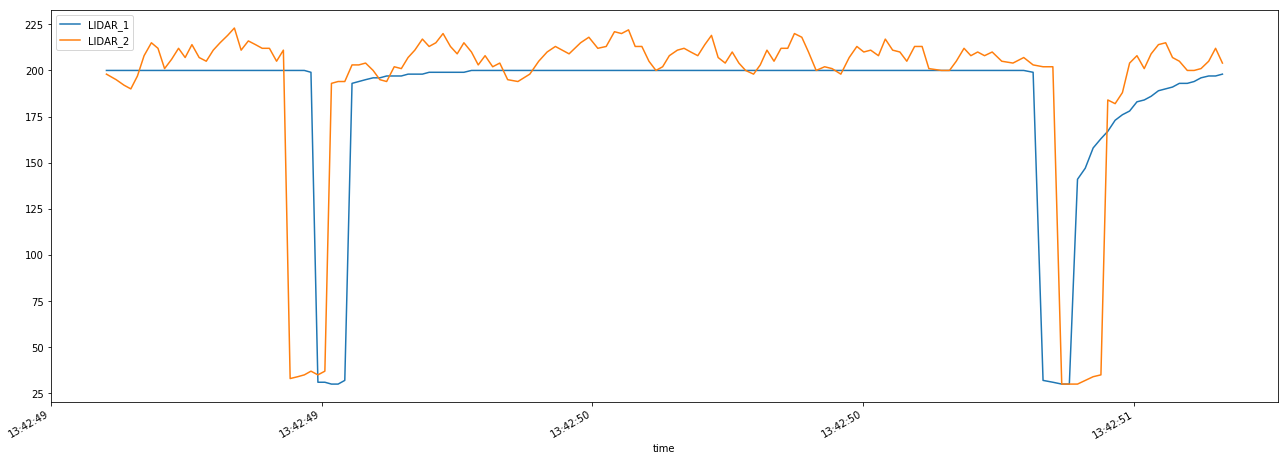

In [9]:
df.iloc[50:200].plot(figsize=FIG_SIZE); # 

Temporal resolution is good enough to distinguish start time of two signals

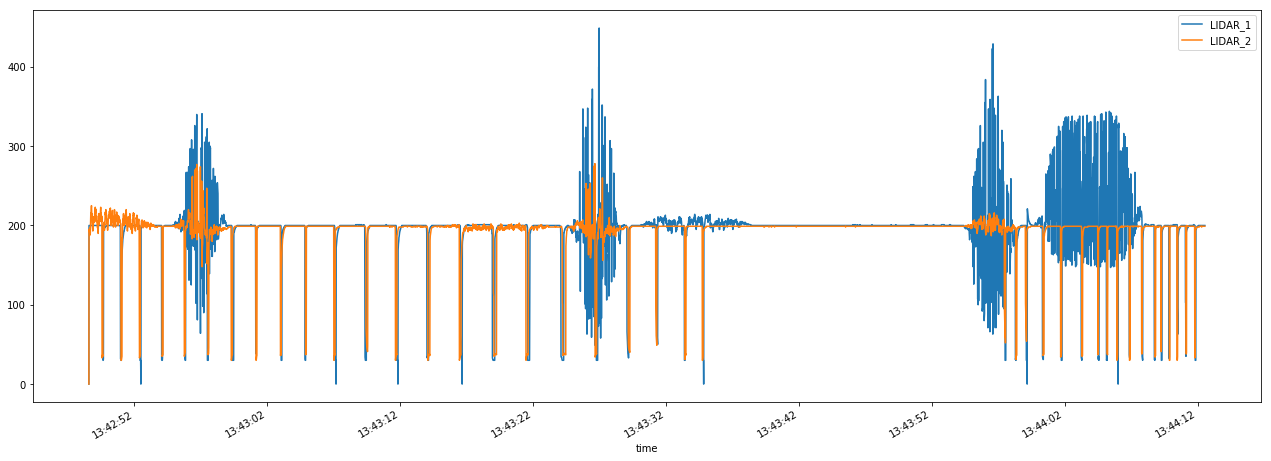

In [10]:
df.plot(figsize=FIG_SIZE); # 

We want to identify changes to the height, so take the diff

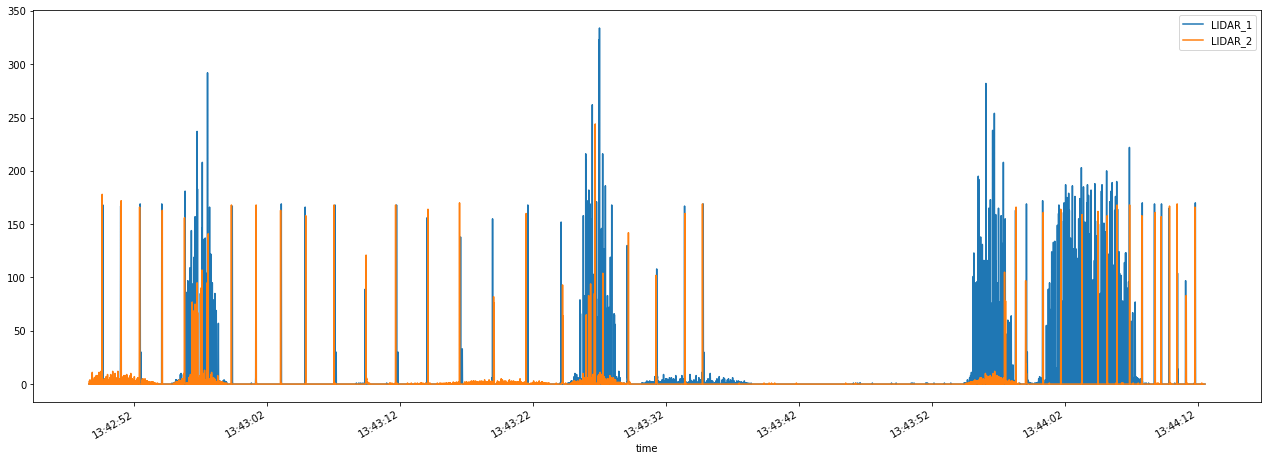

In [11]:
df_diff = df.diff()[df.diff() < 1].abs() # get the negative diffs (as data is inverted) and take the abs to get a positive height
df_diff = df_diff.fillna(0)
df_diff.plot(figsize=FIG_SIZE);

We want to identify pairs of events, which when highly correlated in time are likely a single detection event. Use `rolling` to generate a moving window with some statistic that can be used to identify these events -> choose `max`

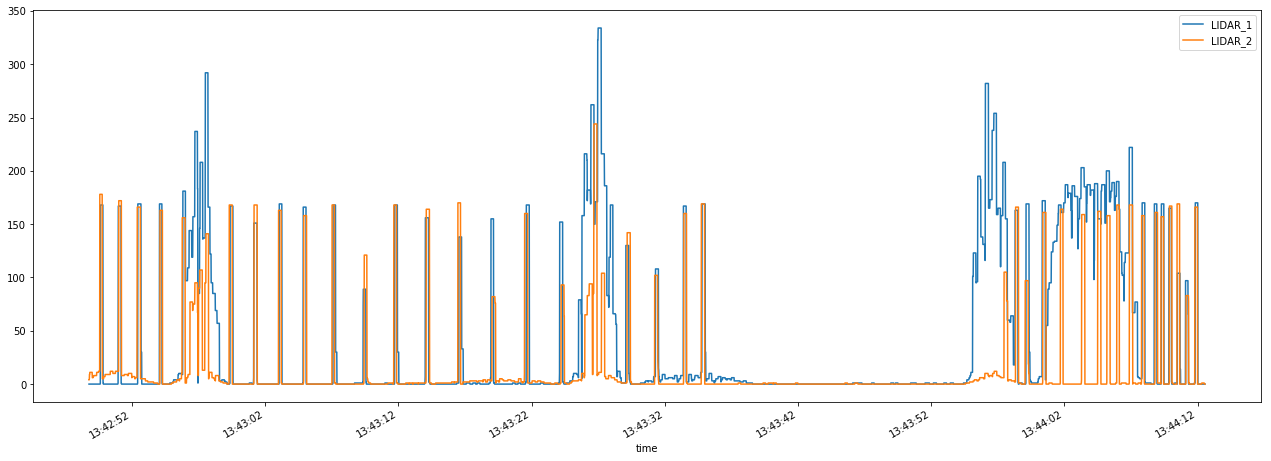

In [12]:
WINDOW = 15 # the number of points in a rolling window - this becomes the hyperparameter to tune

df_diff_rolling_max = df_diff.rolling(WINDOW).max()
df_diff_rolling_max.plot(figsize=FIG_SIZE);

We dont need this window if a person can break both beams at once - achieve by having sensors closer together

## Candidate detection events
When both values are high, the product will be very high -> use to identify detection events

In [13]:
df_diff_rolling_max['product'] = df_diff_rolling_max['LIDAR_1'] * df_diff_rolling_max['LIDAR_2']

Plot candidate detection events

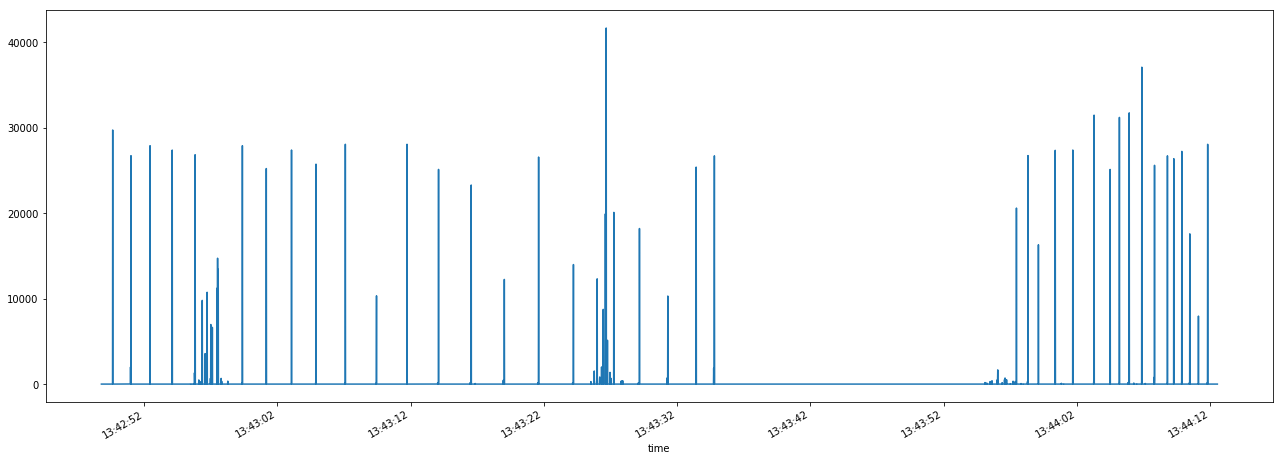

In [14]:
df_diff_product = df_diff_rolling_max['product'].diff()
df_diff_product[df_diff_product < 0] = 0 # drop negative values
df_diff_product.plot(figsize=FIG_SIZE);

Get the events based on the `df_diff_product`

In [15]:
events = list(df_diff_product[df_diff_product > 2000].index)
print(len(events))
events

55


[Timestamp('2019-05-02 13:42:49.648884'),
 Timestamp('2019-05-02 13:42:51.021772'),
 Timestamp('2019-05-02 13:42:52.452165'),
 Timestamp('2019-05-02 13:42:54.116982'),
 Timestamp('2019-05-02 13:42:55.833317'),
 Timestamp('2019-05-02 13:42:56.370159'),
 Timestamp('2019-05-02 13:42:56.585146'),
 Timestamp('2019-05-02 13:42:56.735008'),
 Timestamp('2019-05-02 13:42:57.012069'),
 Timestamp('2019-05-02 13:42:57.089361'),
 Timestamp('2019-05-02 13:42:57.102728'),
 Timestamp('2019-05-02 13:42:57.127650'),
 Timestamp('2019-05-02 13:42:57.486340'),
 Timestamp('2019-05-02 13:42:57.519562'),
 Timestamp('2019-05-02 13:42:57.568103'),
 Timestamp('2019-05-02 13:42:59.380979'),
 Timestamp('2019-05-02 13:43:01.175673'),
 Timestamp('2019-05-02 13:43:03.068181'),
 Timestamp('2019-05-02 13:43:04.905479'),
 Timestamp('2019-05-02 13:43:07.107249'),
 Timestamp('2019-05-02 13:43:09.446506'),
 Timestamp('2019-05-02 13:43:11.737042'),
 Timestamp('2019-05-02 13:43:14.101417'),
 Timestamp('2019-05-02 13:43:16.55

In [16]:
df_diff_product.shape

(6000,)

And compare to our original diff

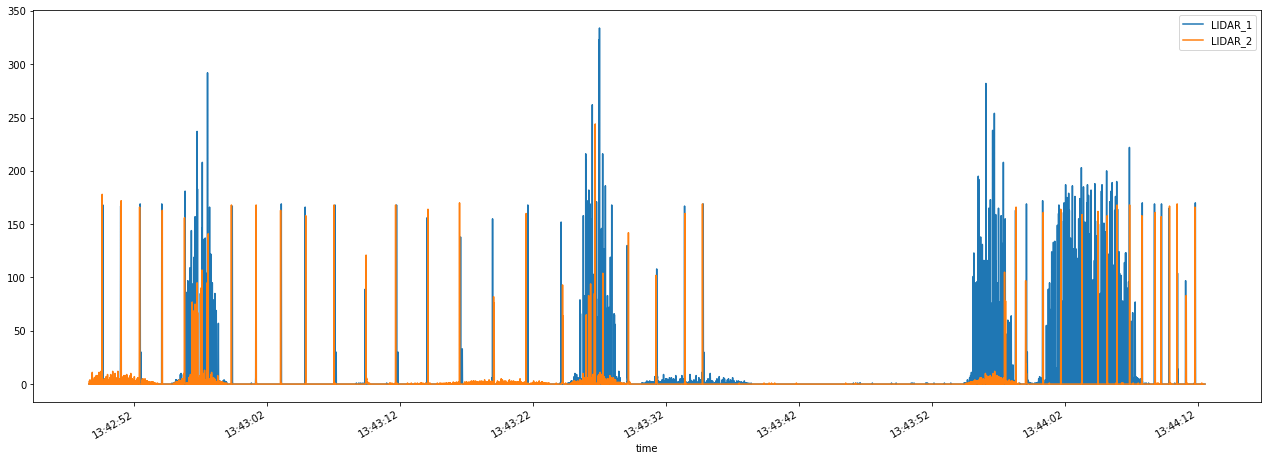

In [17]:
df_diff.plot(figsize=FIG_SIZE);

## Determine order of events
Now want to find the closest signals to events, and determine their order, to decided it if it was an ENTRANCE or EXIT event

* ENTRANCE -> LIDAR_1 was high before LIDAR_2
* EXIT -> LIDAR_2 was high before LIDAR_1

Can we use the 'last triggered' sensor to determine the direction of travel?

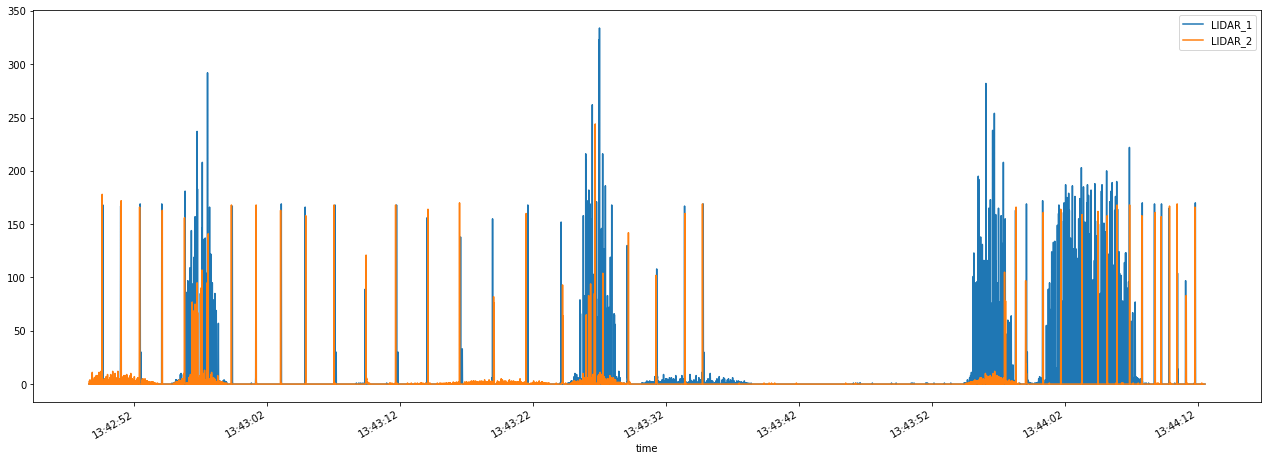

In [18]:
df_diff.plot(figsize=FIG_SIZE);

Write an algo to determine the last triggered sensor

In [19]:
initial_state = 0
states = [initial_state] # initialise an empty state

# iterate over times and determine state at each time
for time in df_diff.index:
    if df_diff.loc[time]['LIDAR_1'] > 50:
        states.append(0)
    elif df_diff.loc[time]['LIDAR_2'] > 50:
        states.append(1)
    else:
        states.append(states[-1]) # append the previous state

states = states[1:] # drop that initial_state

In [20]:
ds_state = pd.Series(data=states, index=df_diff.index)

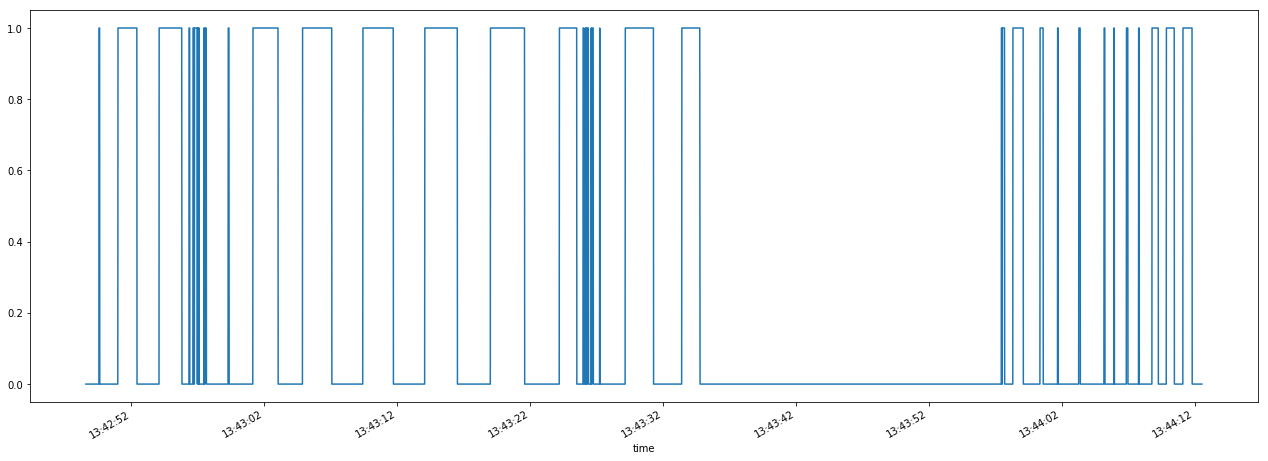

In [21]:
ds_state.plot(figsize=FIG_SIZE);

Now we can look up the last triggered sensor at each event

In [22]:
states_info = ds_state.loc[events]
print(states_info.values.sum())
states_info

31


time
2019-05-02 13:42:49.648884    0
2019-05-02 13:42:51.021772    1
2019-05-02 13:42:52.452165    0
2019-05-02 13:42:54.116982    1
2019-05-02 13:42:55.833317    0
2019-05-02 13:42:56.370159    1
2019-05-02 13:42:56.585146    0
2019-05-02 13:42:56.735008    0
2019-05-02 13:42:57.012069    1
2019-05-02 13:42:57.089361    0
2019-05-02 13:42:57.102728    1
2019-05-02 13:42:57.127650    0
2019-05-02 13:42:57.486340    1
2019-05-02 13:42:57.519562    0
2019-05-02 13:42:57.568103    1
2019-05-02 13:42:59.380979    0
2019-05-02 13:43:01.175673    1
2019-05-02 13:43:03.068181    0
2019-05-02 13:43:04.905479    1
2019-05-02 13:43:07.107249    0
2019-05-02 13:43:09.446506    1
2019-05-02 13:43:11.737042    0
2019-05-02 13:43:14.101417    1
2019-05-02 13:43:16.552916    0
2019-05-02 13:43:19.037718    1
2019-05-02 13:43:21.610689    0
2019-05-02 13:43:24.224212    1
2019-05-02 13:43:26.005573    1
2019-05-02 13:43:26.334385    1
2019-05-02 13:43:26.461275    0
2019-05-02 13:43:26.618546    1
201

Detection is pretty good now getting around 80% (4 of 5) correct events 

In [23]:
accuracy = 100 * states_info.values.sum() / states_info.shape[0] # %
accuracy

56.36363636363637